In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from hmm.hessian import *

In [3]:
from hmm.hmm import HMM
from hmm.gaussian_hmm import GaussHMM

# make a fake model

In [22]:
model = GaussHMM(K = 2, D = 2)

In [23]:
model.means = np.array([ [-1., 1.], [1., 1.] ])
model.covs = np.stack([0.5*np.eye(2) for _ in range(2)])


make fake 2-D data

In [25]:
h,z = model.sample(50)
z.shape

(50, 2)

In [30]:
# get loglikelihood
model.score(z)

IndexError: tuple index out of range

# load a learned model

In [9]:
path_to_model = '/home/gagan/data/zudeep/hmm_dump/r15y5_nz12/day_22_hiddensize_50/model_data_and_scores_day_22.pkl'

In [10]:
mm = joblib.load(path_to_model)

In [9]:
model = mm['model']

In [11]:
traindata = mm['ztrain']
len(traindata)

522

In [11]:
CC = model.covars_
CC.shape

(50, 1, 12, 12)

# prepare the parameters

In [34]:
# do you want to send it to gpu?
CUDA = False

In [35]:
params = {}
params['means'] = model.means_
params['covars'] = np.squeeze(model.covars_)
params['transmat'] = model.transmat_
params['start_prob'] = model.startprob_

mu, cov, A, pi, B, _ = prepare_params_no_redundant(params)
varss = cov[:,0,0]

if CUDA:
    mu = mu.cuda()
    varss = varss.cuda()
    A  = A.cuda()
    pi = pi.cuda()
    B = B.cuda()

ndim = mu.shape[-1]
nstates = mu.shape[0]
totparams = ndim*nstates + nstates + (nstates*(nstates-1)) + (nstates-1)

# check transition matrices for zeros

In [23]:
model.transmat_prior

1.5

In [26]:
TT = model.transmat_

In [27]:
TT.shape

(50, 50)

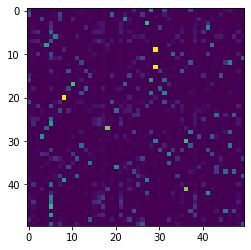

In [29]:
plt.imshow(TT)

In [31]:
model.startprob_prior

1.0

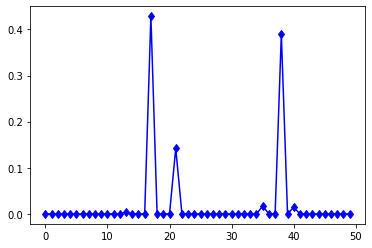

In [30]:
PI = model.startprob_
plt.plot(PI, '-db')

# check hmmlearn likelihood to own function

In [32]:
model.score(traindata[50])

67.77451920440998

In [37]:
isinstance(A, torch.Tensor)

True

In [38]:
logLLcalculation_scaled_noredudantA(traindata[50], mu, varss, A, pi, B, T = traindata[50].shape[0], cuda=False)

tensor(67.7746, grad_fn=<SumBackward0>)

# compute model entropy

In [15]:
# compute entropy for this model
Hsp, Htrans, Hgauss = full_entropy(model)
Htot = Hsp+Htrans+Hgauss
print(Htot)

...... computing Entropy ......
5.041815566369349


# get hessian

In [15]:
# subsample the data
ids = np.random.choice(len(traindata), size=10, replace=False)
zt = [traindata[i] for i in ids]

In [16]:
len(zt)

10

In [ ]:

# get hessian
print('...... computing Hessian over %d sequences ......'%(len(zt)))

Htotal = np.zeros((totparams, totparams))

for i, z in enumerate(zt):
    
    H = compute_hessian(mu, varss, A, pi, B, z, cuda=CUDA)
    
    if np.sum(np.isnan(H))>0.:
        continue
        
    Htotal += H 
    print('# done with %d / %d seqs # '%(i,len(zt)))


Hdet = np.linalg.det(Htotal)

if Hdet == 0.:
    # it shouldn't be zero
    pdb.set_trace()

# loglikelihood
LL =  model.score(np.concatenate(traindata), [len(t) for t in traindata])
# BIC
BIC = -2*LL + np.log(Hdet)